In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'pytorch-retinanet')

In [2]:
%matplotlib inline

In [73]:
#!pip install -U scikit-learn



In [2]:
import matplotlib.pyplot as plt
import cv2
from sklearn import cluster
import numpy as np

In [3]:
image = cv2.imread('images/baseball_field1.png') / 255

In [4]:
copy = image.copy()
copy[copy == 0] = 1

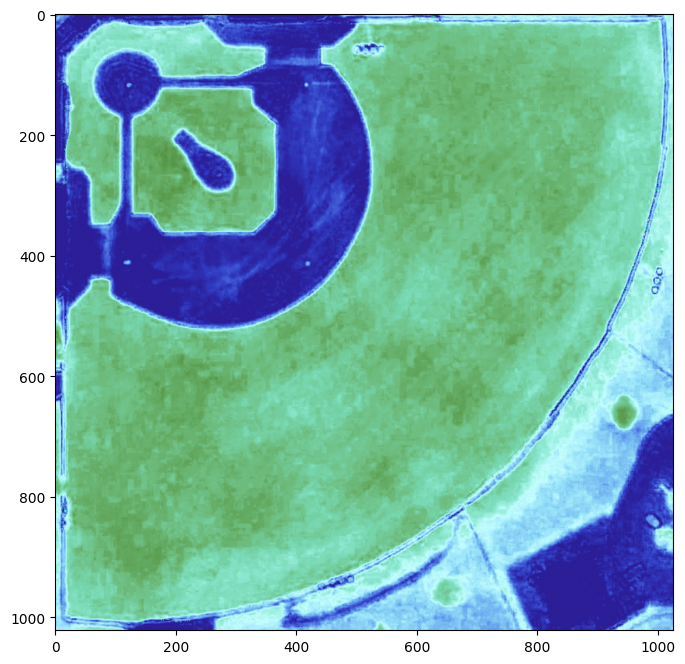

In [5]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(copy)
plt.show()

In [6]:
x, y, z = image.shape
image_2d = image.reshape(x*y, z)
image_2d.shape

(1048572, 3)

In [7]:
kmeans_cluster = cluster.KMeans(n_clusters=4)
kmeans_cluster.fit(image_2d)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [8]:
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_
print(cluster_centers.shape, cluster_labels.shape)

segmented_image = cluster_centers[cluster_labels].reshape(x, y, z)

(4, 3) (1048572,)


In [9]:
# values to recognize the different clusters from kmeans
value = [4.69527965e-01, 8.39158637e-01, 7.10461527e-01]
min_ = 10000
label = 0
for i, c in enumerate(cluster_centers):
    cmp = np.min((np.abs(c-value)).sum()/3)
    if min_> cmp:
        min_ = cmp
        label = i
        
print('min', min_, label)

min 0.022052576871923597 3


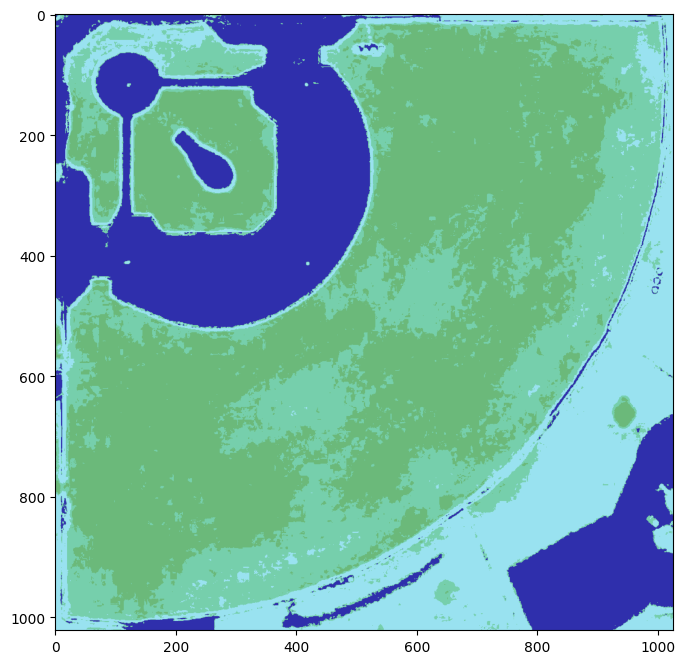

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image)
plt.show()

In [13]:
path = 'images'
# names = ['2021-7-13_field1_w0_h0', '2021-7-13_field1_w7680_h0', '2021-7-13_field1_w17920_h12800', '2021-7-13_field1_w17920_h14080', '2021-7-13_field1_w17920_h15360', '2021-7-13_field1_w17920_h16640']
names = ['2021-7-13_field1_w0_h0', '2021-7-13_field1_w7680_h0', '2021-7-13_field1_w17920_h12800', '2021-7-13_field1_w17920_h14080', '2021-7-13_field1_w17920_h15360', '2021-7-13_field1_w17920_h16640']

name = names[4] # pick one of the sample images

# img = cv2.imread(f'{path}/NDVI/{name}.png') / 255
img = image
ndvi = img.copy()

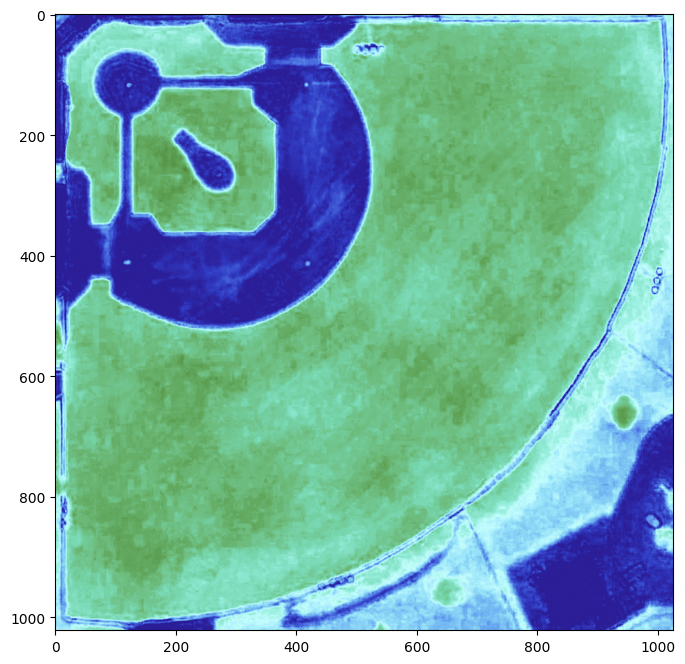

In [14]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.show()

In [15]:
x, y, z = img.shape
img_2d = img.reshape(x*y, z)
img_2d.shape

(1048572, 3)

In [16]:
out = kmeans_cluster.predict(img_2d)
out.shape

(1048572,)

In [17]:
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = out
print(cluster_centers.shape, cluster_labels.shape)

segmented_image = cluster_centers[cluster_labels].reshape(x, y, z)

(4, 3) (1048572,)


In [18]:
cluster_labels = kmeans_cluster.predict(img_2d)
row, col = np.where(cluster_labels.reshape(x, y) == label)
to_use = np.where(cluster_labels.reshape(x, y) == label)
print(type(to_use))
to_use = np.asarray(to_use).T
print(to_use.shape, row.reshape(row.shape[0], 1).shape, col.shape)

<class 'tuple'>
(252458, 2) (252458, 1) (252458,)


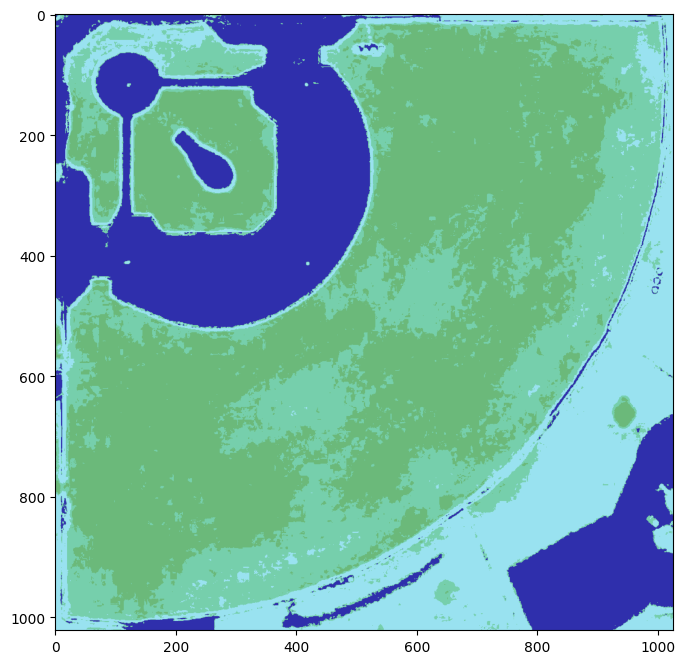

In [19]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image)
plt.show()

# Cluster based on positions

In [20]:
from sklearn.cluster import DBSCAN
if to_use.shape[0] != 0:
    clustering = DBSCAN(eps=10, min_samples=300).fit(to_use)
    clustering.labels_.shape, to_use.shape

# Draw BBOX

In [21]:
if to_use.shape[0] != 0:
    sel = 0
    segmented_image2 = img.copy() * 255
    for sel in np.unique(clustering.labels_):
        ind = clustering.labels_ == sel
        y1, y2 = np.min(to_use[ind, 0]), np.max(to_use[ind, 0])
        x1, x2 = np.min(to_use[ind, 1]), np.max(to_use[ind, 1])
        print(sel, x1, y1, x2, y2)
        if sel != -1:
            segmented_image2 = cv2.rectangle(segmented_image2, (x1, y1), (x2, y2), (255, 255, 255), 10)

    segmented_image2 = segmented_image2 / 255

-1 0 0 1025 1021
0 975 13 1002 53
1 811 16 968 122
2 86 22 124 42
3 183 39 339 101
4 166 46 192 68
5 859 50 897 76
6 456 60 496 98
7 31 69 50 88
8 496 79 519 106
9 737 83 1005 679
10 21 86 63 143
11 44 172 67 197
12 341 187 361 218
13 531 192 558 220
14 496 389 681 530
15 434 453 454 477
16 446 454 485 494
17 51 462 85 500
18 108 488 155 541
19 187 517 216 539
20 294 517 340 545
21 26 557 45 576
22 469 557 493 583
23 332 575 495 707
24 19 577 47 620
25 826 608 846 630
26 19 619 51 651
27 306 631 329 651
28 733 668 758 691
29 287 683 355 723
30 750 692 783 727
31 49 696 69 718
32 420 703 445 725
33 165 723 730 994
34 725 724 757 756
35 698 748 786 827
36 451 793 471 817
37 19 853 53 888
38 20 918 106 1003
39 629 938 663 979
40 111 970 138 1005


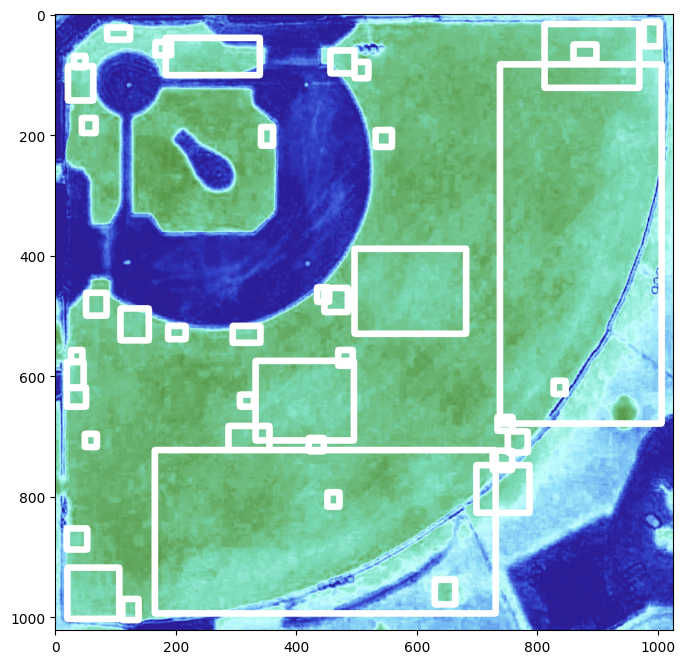

In [22]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image2)
plt.show()

# Model Output

In [23]:
class Parser:
    pass

# creates a parser
parser = Parser()
parser.supervised = True
parser.depth = 50
parser.num_classes = 1
parser.dim_out = 32
parser.model_path = 'weights/model_final.pt'

In [24]:
from retinanet import model
import torch
import torch.nn as nn

In [25]:
retinanet = model.resnet50(num_classes=1, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to ./resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.2MB/s]


In [30]:
use_gpu = False

if torch.cuda.is_available():
    print('loading')
    retinanet.load_state_dict(torch.load(parser.model_path).module.state_dict())
    retinanet = torch.nn.DataParallel(retinanet).cuda()
else:
    print('loading')
    retinanet.load_state_dict(torch.load(parser.model_path))
    retinanet = torch.nn.DataParallel(retinanet)

if use_gpu:
    if torch.cuda.is_available():
        retinanet = retinanet.cuda()


retinanet.training = False
retinanet.module.freeze_bn()
retinanet.eval();

loading


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [120]:
img = cv2.imread(f'{path}/NDVI/{name}.png')
img = img.astype(np.float32)/255.0

In [121]:
from retinanet.dataloader import Normalizer, Resizer

In [122]:
#!pip install scikit-image

In [123]:
norm = Normalizer()
resizer = Resizer()

default = np.expand_dims(np.array([0, 0, 10, 10, 0]), 0)
default = default.astype('float64')

sample = {'img': img, 'annot': default}
sample = norm(sample)
sample = resizer(sample)
img = sample['img']

In [124]:
tensor_img = img.unsqueeze(0).permute(0, 3, 1, 2)
tensor_img = tensor_img.float().detach()
tensor_img.shape

torch.Size([1, 3, 1312, 1312])

In [125]:
import time
with torch.no_grad():
    scores, labels, boxes = retinanet(tensor_img)

In [126]:
scores = scores.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()
boxes  = boxes.cpu().detach().numpy()

In [127]:
# DRAW BOXES
segmented_image3 = segmented_image2.copy()
for box in boxes:
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    segmented_image3 = cv2.rectangle(segmented_image3, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


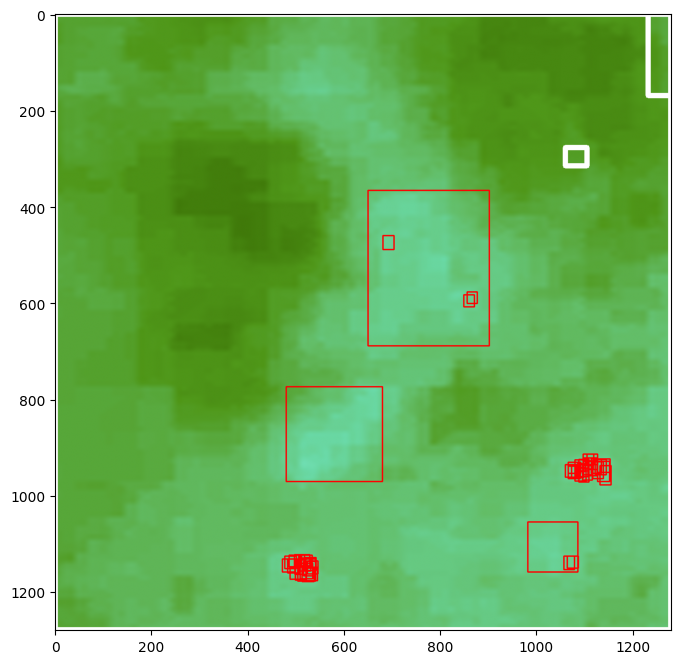

In [128]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image3)
plt.show()